In [1]:
# загрузим библиотеки и установим опции

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:
1.169*1.169/4

0.34164025000000003

In [3]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('data/train_sessions.csv',index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv',index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [4]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'всего сайтов:', sites_dict.shape[0])
sites_dict.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [5]:
# топ-сайты в обучающей выборке
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.ix[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


In [6]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [7]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [48]:
time_df = pd.read_csv('data/all_time_not_nan.csv')

In [49]:
time_df.shape

(336358, 101)

In [53]:
col = time_df.columns
col = list(set(col)-{'target'})

In [54]:
tmp_scaled = StandardScaler().fit_transform(time_df[col])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.955694861093


In [55]:
idx_split

253561

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int').astype('str')
test_df[sites] = test_df[sites].fillna(0).astype('int').astype('str')

train_df['list'] = train_df['site1']
test_df['list'] = test_df['site1']
for s in sites[1:]:
    train_df['list'] = train_df['list']+" "+train_df[s]
    test_df['list'] = test_df['list']+" "+test_df[s]
    


In [9]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # разделим выборку на обучающую и валидационную
    idx = round(X.shape[0] * ratio)
    # обучение классификатора
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # прогноз для валидационной выборки
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # считаем качество
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorizer = TfidfVectorizer(sublinear_tf=True,ngram_range=(1, 10),max_features = 50000)
vectorizer.fit(train_df['list'])

X_train = vectorizer.transform(train_df['list'])
Xtest = vectorizer.transform(test_df['list'])
print(X_train.shape,Xtest.shape)
#print(get_auc_lr_valid(X_train, y_train))

(253561, 50000) (82797, 50000)


In [38]:
print(get_auc_lr_valid(X_train, y_train))

0.929687764179


In [ ]:
0.929687764179

In [52]:
full_new_feat.head()

,start_day_y,start_month,start_day,long,start_hour,morning
session_id,,,,,,
21669,20130112,201301,201312,0.0,8,1
54843,20130112,201301,201312,0.0,8,1
77292,20130112,201301,201312,0.0,8,1
114021,20130112,201301,201312,0.0,8,1
146670,20130112,201301,201312,0.0,8,1


In [67]:
def weekand(x):
    if x>4:
        return 1
    else:
        return 0

In [68]:
full_new_feat = pd.DataFrame(index=full_df.index)

# добавим признак start_month
#full_new_feat['start'] = full_df['time1'].apply(lambda ts: 1000000 * ts.year +ts.month*10000+ ts.day*100+ts.hour)
full_new_feat['start_day_y'] = full_df['time1'].apply(lambda ts: 10000 * ts.year +ts.month*100+ ts.day)
#full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
#full_new_feat['start_moth_mh'] = full_df['time1'].apply(lambda ts: ts.month*10000+ ts.day*100+ts.hour)
full_new_feat['start_moth_dh'] = full_df['time1'].apply(lambda ts: ts.day*100+ts.hour)
#full_new_feat['day'] = full_df['time1'].apply(lambda ts: ts.day)
#full_new_feat['minut'] = full_df['time1'].apply(lambda x: x.minute)
full_new_feat['weekday'] = full_df['time1'].apply(lambda x: x.dayofweek)
#full_new_feat['dayofyear'] = full_df['time1'].apply(lambda x: x.dayofyear)
#full_new_feat['weekand'] = full_new_feat['weekday'].apply(weekand)
full_new_feat['start_week'] = 100*full_new_feat['weekday']+full_df['time1'].apply(lambda ts:  ts.hour)
full_new_feat['long'] = (full_df['time2'].apply(lambda ts:  ts.minute)-full_df['time1'].apply(lambda ts:  ts.minute))%3600
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_new_feat['morning'] = full_new_feat['start_hour'].apply(lambda hour: int(hour <= 10))
full_new_feat['sec_in_day'+"time1"] = full_df['time1'].apply(lambda x: 60*x.minute+x.second)
for t in times[1:]:
    full_new_feat['sec_in_day'+t] = full_df[t].apply(lambda x: 60*60*x.hour + 60*x.minute+x.second)

In [41]:
full_new_feat.head()

,start_day_y,start_moth_dh,weekday,start_week,long,start_hour,morning,sec_in_daytime1,sec_in_daytime2,sec_in_daytime3,sec_in_daytime4,sec_in_daytime5,sec_in_daytime6,sec_in_daytime7,sec_in_daytime8,sec_in_daytime9,sec_in_daytime10
session_id,,,,,,,,,,,,,,,,,
21669,20130112,1208,5,508,0.0,8,1,357,29157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54843,20130112,1208,5,508,0.0,8,1,2243,31043.0,32827.0,32829.0,NaN,NaN,NaN,NaN,NaN,NaN
77292,20130112,1208,5,508,0.0,8,1,3013,31814.0,31815.0,31815.0,31816.0,31816.0,31816.0,31816.0,31817.0,31817.0
114021,20130112,1208,5,508,0.0,8,1,3017,31817.0,31818.0,31818.0,31818.0,31818.0,31819.0,31819.0,31819.0,31820.0
146670,20130112,1208,5,508,0.0,8,1,3020,31820.0,31820.0,31821.0,31821.0,31821.0,31821.0,31822.0,31822.0,31822.0


In [69]:
for i in range(len(times)-1):
    t1 = times[i]
    t2 = times[i+1]
    full_new_feat['delta_sec'+t2] = (full_new_feat['sec_in_day'+t2]-full_new_feat['sec_in_day'+t1])%3600
full_new_feat.head()

,start_day_y,start_moth_dh,weekday,start_week,long,start_hour,morning,sec_in_daytime1,sec_in_daytime2,sec_in_daytime3,...,sec_in_daytime10,delta_sectime2,delta_sectime3,delta_sectime4,delta_sectime5,delta_sectime6,delta_sectime7,delta_sectime8,delta_sectime9,delta_sectime10
session_id,,,,,,,,,,,,,,,,,,,,,
21669,20130112,1208,5,508,0.0,8,1,357,29157.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54843,20130112,1208,5,508,0.0,8,1,2243,31043.0,32827.0,...,NaN,0.0,1784.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
77292,20130112,1208,5,508,0.0,8,1,3013,31814.0,31815.0,...,31817.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
114021,20130112,1208,5,508,0.0,8,1,3017,31817.0,31818.0,...,31820.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
146670,20130112,1208,5,508,0.0,8,1,3020,31820.0,31820.0,...,31822.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [52]:
sites = ['delta_sectime%s' % i for i in range(2, 11)]
full_new_feat[sites] = full_new_feat[sites].fillna(-1).astype('int').astype('str')

full_new_feat['list_d'] = full_new_feat['delta_sectime2']
for s in sites[1:]:
    full_new_feat['list_d'] = full_new_feat['list_d']+" "+full_new_feat[s]
    

In [53]:
full_new_feat.head()

,start_day_y,start_moth_dh,weekday,start_week,long,start_hour,morning,sec_in_daytime1,sec_in_daytime2,sec_in_daytime3,...,delta_sectime2,delta_sectime3,delta_sectime4,delta_sectime5,delta_sectime6,delta_sectime7,delta_sectime8,delta_sectime9,delta_sectime10,list_d
session_id,,,,,,,,,,,,,,,,,,,,,
21669,20130112,1208,5,508,0.0,8,1,357,29157.0,NaN,...,0,-1,-1,-1,-1,-1,-1,-1,-1,0 -1 -1 -1 -1 -1 -1 -1 -1
54843,20130112,1208,5,508,0.0,8,1,2243,31043.0,32827.0,...,0,1784,2,-1,-1,-1,-1,-1,-1,0 1784 2 -1 -1 -1 -1 -1 -1
77292,20130112,1208,5,508,0.0,8,1,3013,31814.0,31815.0,...,1,1,0,1,0,0,0,1,0,1 1 0 1 0 0 0 1 0
114021,20130112,1208,5,508,0.0,8,1,3017,31817.0,31818.0,...,0,1,0,0,0,1,0,0,1,0 1 0 0 0 1 0 0 1
146670,20130112,1208,5,508,0.0,8,1,3020,31820.0,31820.0,...,0,0,1,0,0,0,1,0,0,0 0 1 0 0 0 1 0 0


In [59]:
vectorizer = TfidfVectorizer(sublinear_tf=True,ngram_range=(1, 9),max_features = 50000)
vectorizer.fit(full_new_feat['list_d'])

X_train_d = vectorizer.transform(full_new_feat['list_d'])
print(X_train.shape,Xtest.shape)
#print(get_auc_lr_valid(X_train, y_train))

(253561, 50000) (82797, 50000)


In [60]:

print(get_auc_lr_valid(X_train_d[:idx_split,:], y_train))

0.593654216121


In [ ]:
.58745936167

In [53]:
full_new_feat =  pd.get_dummies(full_new_feat,columns = ['day']).rename(columns=lambda x: str(x))
print(full_new_feat.shape)
full_new_feat.head()

(336358, 35)


,start_day_y,start_month,minut,weekday,dayofyear,weekand,start_week,long,start_hour,morning,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
session_id,,,,,,,,,,,,,,,,,,,,,
21669,20130112,201301,5,5,12,1,508,0.0,8,0,...,0,0,0,0,0,0,0,0,0,0
54843,20130112,201301,37,5,12,1,508,0.0,8,0,...,0,0,0,0,0,0,0,0,0,0
77292,20130112,201301,50,5,12,1,508,0.0,8,0,...,0,0,0,0,0,0,0,0,0,0
114021,20130112,201301,50,5,12,1,508,0.0,8,0,...,0,0,0,0,0,0,0,0,0,0
146670,20130112,201301,50,5,12,1,508,0.0,8,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
def divide(a, b):
    if b>0:
        return a/b
    else:
        return 0

In [71]:
full_new_feat['mean-med'] = full_new_feat['mean'] - full_new_feat['median']
#time_df['razmah_75_25'] = time_df['perc_75'] - time_df['perc_25']
full_new_feat['koef_oscil'] = full_new_feat.apply(lambda row: divide(row['max-min'], row['mean']), axis=1)
full_new_feat['koef_oscil_med'] = full_new_feat.apply(lambda row: divide(row['max-min'], row['median']), axis=1)
full_new_feat['koef_var_'] = full_new_feat.apply(lambda row: divide(row['std'], row['mean']), axis=1)
full_new_feat['koef_var_med'] = full_new_feat.apply(lambda row: divide(row['std'], row['median']), axis=1)
#time_df['koef_quant_'] = time_df.apply(lambda row: divide(row['razmah_75_25'], row['mean']), axis=1)
#time_df['koef_quant_med'] = time_df.apply(lambda row: divide(row['razmah_75_25'], row['median']), axis=1)
full_new_feat['mean/med'] = full_new_feat.apply(lambda row: divide(row['mean'], row['median']), axis=1)


KeyError: 'mean'

In [ ]:
full_new_feat.columns

In [126]:
li = ['mean-med', 'koef_oscil',
       'koef_oscil_med', 'koef_var_', 'koef_var_med', 'mean/med']

In [ ]:
X_train_d

In [76]:
full_new_feat = full_new_feat.fillna(0)

In [128]:
for c in li:
    tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_moth_dh', 'start_hour','start_day_y',\
                                                          'start_week','long','max-min','sec_in_daytime10','delta_sectime10',\
                                                          'std','kurtosis',c]])
    X_tr = csr_matrix(hstack([X_train, 
                                 tmp_scaled[:idx_split,:]]))
    print(c,get_auc_lr_valid(X_tr, y_train))

mean-med 0.977915513335
koef_oscil 0.977722586941
koef_oscil_med 0.977865092822
koef_var_ 0.977728172447
koef_var_med 0.977862677468
mean/med 0.977898454898


In [72]:
times_delta = ['delta_sectime%s'% i for i in range(2,11)]

In [73]:
from scipy.stats import kurtosis,skew, mode

In [74]:
full_new_feat['max-min'] = full_new_feat[times_delta].max(axis=1) - full_new_feat[times_delta].min(axis=1)
full_new_feat['std'] = full_new_feat[times_delta].std(axis=1)
full_new_feat['mean'] = full_new_feat[times_delta].mean(axis=1)
full_new_feat['median'] = full_new_feat[times_delta].median(axis=1)
full_new_feat['max'] = full_new_feat[times_delta].max(axis=1)
full_new_feat['min'] = full_new_feat[times_delta].min(axis=1)
full_new_feat['sem'] = full_new_feat[times_delta].sem(axis=1)
full_new_feat['sum'] = full_new_feat[times_delta].sum(axis=1)
full_new_feat['kurtosis'] = full_new_feat[times_delta].kurtosis(axis=1)
full_new_feat['skew'] = full_new_feat[times_delta].skew(axis=1)
#time_df['mode'] = time_df[times_delta].mode(axis=1)#error
full_new_feat['max+min'] = (full_new_feat['max'] + full_new_feat['min'])*0.5
full_new_feat.head()

,start_day_y,start_moth_dh,weekday,start_week,long,start_hour,morning,sec_in_daytime1,sec_in_daytime2,sec_in_daytime3,...,std,mean,median,max,min,sem,sum,kurtosis,skew,max+min
session_id,,,,,,,,,,,,,,,,,,,,,
21669,20130112,1208,5,508,0.0,8,1,357,29157.0,NaN,...,NaN,0.000000,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0
54843,20130112,1208,5,508,0.0,8,1,2243,31043.0,32827.0,...,1029.416016,595.333333,2.0,1784.0,0.0,594.333614,1786.0,NaN,1.732043,892.0
77292,20130112,1208,5,508,0.0,8,1,3013,31814.0,31815.0,...,0.527046,0.444444,0.0,1.0,0.0,0.175682,4.0,-2.571429,0.271052,0.5
114021,20130112,1208,5,508,0.0,8,1,3017,31817.0,31818.0,...,0.500000,0.333333,0.0,1.0,0.0,0.166667,3.0,-1.714286,0.857143,0.5
146670,20130112,1208,5,508,0.0,8,1,3020,31820.0,31820.0,...,0.440959,0.222222,0.0,1.0,0.0,0.146986,2.0,0.734694,1.619848,0.5


In [80]:
from gensim.models import word2vec

In [83]:
sites = ['site%s' % i for i in range(1, 11)]
train_df['list'] = train_df['site1']
test_df['list'] = test_df['site1']
for s in sites[1:]:
    train_df['list'] = train_df['list']+","+train_df[s]
    test_df['list'] = test_df['list']+","+test_df[s]
train_df['list_w'] = train_df['list'].apply(lambda x: x.split(','))
test_df['list_w'] = test_df['list'].apply(lambda x: x.split(','))

In [84]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time7,site8,time8,site9,time9,site10,time10,target,list,list_w
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,"56,55,0,0,0,0,0,0,0,0","[56, 55, 0, 0, 0, 0, 0, 0, 0, 0]"
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,"56,55,56,55,0,0,0,0,0,0","[56, 55, 56, 55, 0, 0, 0, 0, 0, 0]"
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,"946,946,951,946,946,945,948,784,949,946","[946, 946, 951, 946, 946, 945, 948, 784, 949, ..."
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,"945,948,949,948,945,946,947,945,946,946","[945, 948, 949, 948, 945, 946, 947, 945, 946, ..."
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,"947,950,948,947,950,952,946,951,946,947","[947, 950, 948, 947, 950, 952, 946, 951, 946, ..."


In [85]:
model = word2vec.Word2Vec(train_df['list_w'], size=300, window=3, workers=4)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [148]:
%%time
Xtr_tfidf = tfidf_vectorizer(w2v).fit(train_df['list_w']).transform(train_df['list_w'])
Xval_tfidf = tfidf_vectorizer(w2v).fit(train_df['list_w']).transform(test_df['list_w'])

KeyboardInterrupt: 

In [90]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))
    
    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    

In [91]:
Xtr_tfidf = mean_vectorizer(w2v).fit(train_df['list_w']).transform(train_df['list_w'])

In [92]:
Xtr_tfidf.shape,X_train.shape

((253561, 300), (253561, 50000))

In [93]:
get_auc_lr_valid(Xtr_tfidf, y_train, C=1, seed=7, ratio = 0.8)

0.90001210973218193

In [94]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_moth_dh', 'start_hour','start_day_y',\
                                                          'start_week','long','max-min','sec_in_daytime10','delta_sectime10',\
                                                          'std','kurtosis']])
X_tr = csr_matrix(hstack([Xtr_tfidf,X_train]))
print(get_auc_lr_valid(X_tr, y_train))

0.931989445507


In [96]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_moth_dh', 'start_hour','start_day_y',\
                                                          'start_week','long','max-min','sec_in_daytime10','delta_sectime10',\
                                                          'std','kurtosis']])
X_tr = csr_matrix(hstack([Xtr_tfidf,X_train,tmp_scaled[:idx_split,:]]))
print(get_auc_lr_valid(X_tr, y_train))

0.976621487472


In [152]:
print(get_auc_lr_valid(Xtr_tfidf, y_train))

0.525153571222


In [ ]:
print(get_auc_lr_valid(Xtr_tfidf, y_train))

In [ ]:
0.925667105657

In [ ]:
X_train_d

In [61]:

X_tr = csr_matrix(hstack([X_train, 
                             X_train_d[:idx_split,:]]))
print(get_auc_lr_valid(X_tr, y_train))

0.927019552894


In [62]:

print(get_auc_lr_valid(X_train, y_train))

0.929687764179


In [77]:

tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_moth_dh', 'start_hour','start_day_y',\
                                                          'start_week','long','max-min','sec_in_daytime10','delta_sectime10',\
                                                          'std','kurtosis']])
X_tr = csr_matrix(hstack([X_train, 
                             tmp_scaled[:idx_split,:]]))
print(get_auc_lr_valid(X_tr, y_train))

0.978786550343


In [ ]:
0.963523476032
0.964
0.9656
0.974226664058
0.97624
0.976514306141
0.977696923805

In [31]:
%%time
# набор возможных значений С
Cs = np.logspace(-3, 1, 10)

scores = []
    
for C in Cs:
    scores.append(get_auc_lr_valid(X_tr, y_train, C=C))

CPU times: user 37.7 s, sys: 644 ms, total: 38.4 s
Wall time: 19.3 s


In [32]:
C = Cs[scores.index(max(scores))]
print(C)

3.5938136638


NameError: name 'score_C_1' is not defined

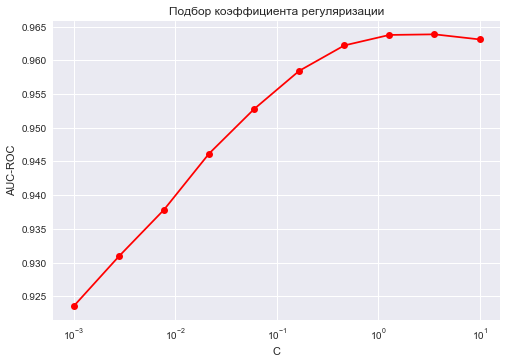

In [33]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')
# горизонтальная линия -- качество модели с коэффициентом по умолчанию
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

In [ ]:
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_2.csv')

In [ ]:
from sklearn.decomposition import TruncatedSVD
TR = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=5, random_state=7)

# send

In [78]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [79]:
X_te = csr_matrix(hstack([Xtest, tmp_scaled[idx_split:,:]]))

# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=3, random_state=7).fit(X_tr, y_train)

# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_te)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'pred/tfidf50k_base_time_base.csv')

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int').astype('str')
test_df[sites] = test_df[sites].fillna(0).astype('int').astype('str')

train_df['list'] = train_df['site1']
test_df['list'] = test_df['site1']
for s in sites[1:]:
    train_df['list'] = train_df['list']+" "+train_df[s]
    test_df['list'] = test_df['list']+" "+test_df[s]
    


In [19]:
y = train_df['target']

In [27]:
def split(train,y,ratio):
    idx = round(train.shape[0] * ratio)
    return train[:idx], train[idx:], y[:idx], y[idx:]
Xtr, Xval, ytr, yval = split(train_df, y,0.9)
Xtr.shape,Xval.shape,ytr.mean(),yval.mean()

((228205, 22), (25356, 22), 0.008908656690256568, 0.010411736867013724)

In [28]:
cv = CountVectorizer()
cv.fit(Xtr['list'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [29]:
Xtr = cv.transform(Xtr['list'])
Xval = cv.transform(Xval['list'])
Xtr.shape,Xval.shape

((228205, 38644), (25356, 38644))

In [36]:
%%time
logit = LogisticRegression(C=1.0,n_jobs=-1, random_state=17)
logit.fit(Xtr, ytr)

CPU times: user 9.08 s, sys: 112 ms, total: 9.19 s
Wall time: 4.65 s


In [39]:
roc_auc_score(yval, logit.predict_proba(Xval)[:,1])

0.91668100783057738

In [23]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # разделим выборку на обучающую и валидационную
    idx = round(X.shape[0] * ratio)
    # обучение классификатора
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # прогноз для валидационной выборки
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # считаем качество
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [35]:
print(get_auc_lr_valid(Xtr, ytr))

0.919409662727


# Hash

In [41]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(stop_words = 'english',non_negative=True,n_features = 15000)
def split(train,y,ratio):
    idx = round(train.shape[0] * ratio)
    return train[:idx], train[idx:], y[:idx], y[idx:]
Xtr, Xval, ytr, yval = split(train_df, y,0.9)
Xtr.shape,Xval.shape,ytr.mean(),yval.mean()
hv.fit(Xtr['list'])
#print(len(hv.vocabulary_))

Xtr = hv.transform(Xtr['list'])
Xval = hv.transform(Xval['list'])
print(Xtr.shape,Xval.shape)
logit.fit(Xtr, ytr)
yLogith15k = logit.predict_proba(Xval)
roc_auc_score(yval, yLogith15k[:,1])


(228205, 15000) (25356, 15000)


0.91464577023221216